> Extracting images from video
done


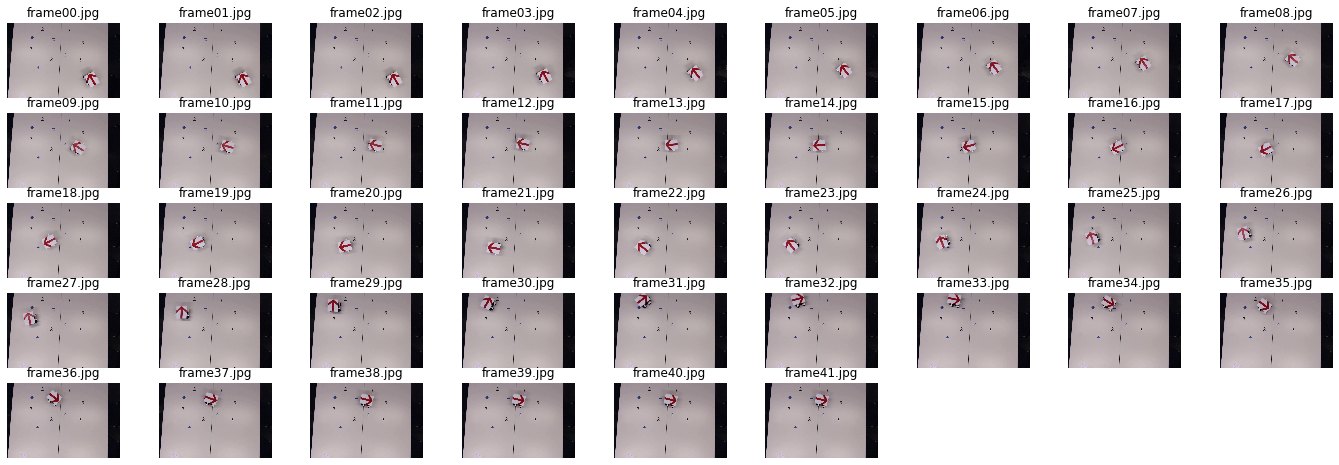

In [1]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data()

# plot images
fig, axes = plt.subplots(5, int(len(images)/5)+1, figsize=(24, 8))
for ax, im, nm in zip(axes.ravel(), images, images_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   
for ax in axes.ravel()[len(images):]:
    fig.delaxes(ax)

In [2]:
print(images[0].shape)

(480, 720, 3)


<b>###############################################################################################################################################################################################################</b> <br>

In [3]:
from helpers import get_arrow_bb
test_im = images[0].copy()
minr_a, minc_a, maxr_a, maxc_a = get_arrow_bb(test_im)

In [84]:
import skimage
from skimage import exposure
from skimage.filters import threshold_multiotsu
from skimage import morphology

def segmentation(image):
    test_im = image.copy()
    test_im[minr_a-30:maxr_a+50, minc_a-30:maxc_a+50] = 255
    plt.figure(figsize=(10,6))
    plt.imshow(test_im)
    
    gray = skimage.color.rgb2gray(test_im)
    
    # Contrast stretching
    a, b = np.percentile(gray, (1, 70))
    img_rescale = exposure.rescale_intensity(gray, in_range=(a, b))
    
    # Threshols
    thresholds = threshold_multiotsu(img_rescale)
    
    # Using the threshold values, we generate the three regions.
    regions = np.digitize(gray, bins=thresholds)
    
    # Binarization 
    binarized = regions == 0
    
    # Morphological operation
    close = morphology.binary_dilation(binarized, skimage.morphology.selem.rectangle(1, 3))
    
    return close
        

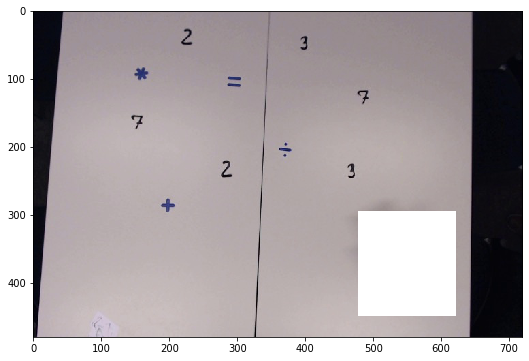

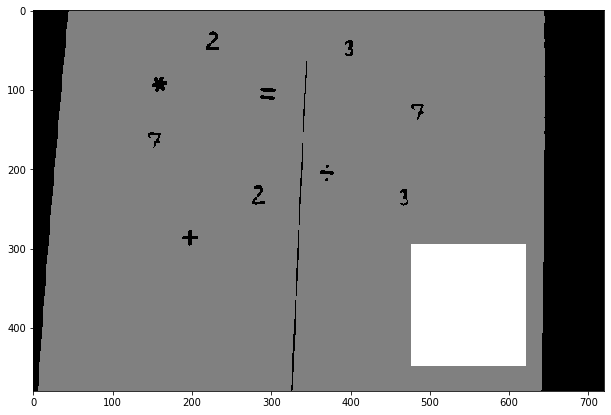

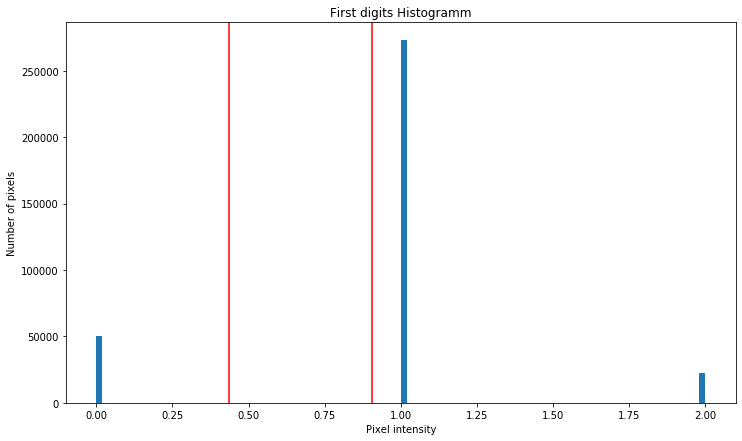

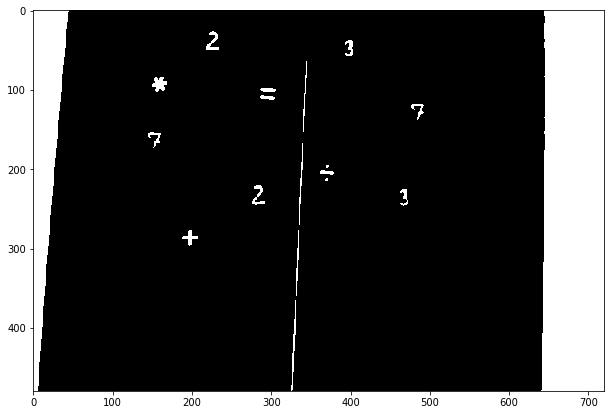

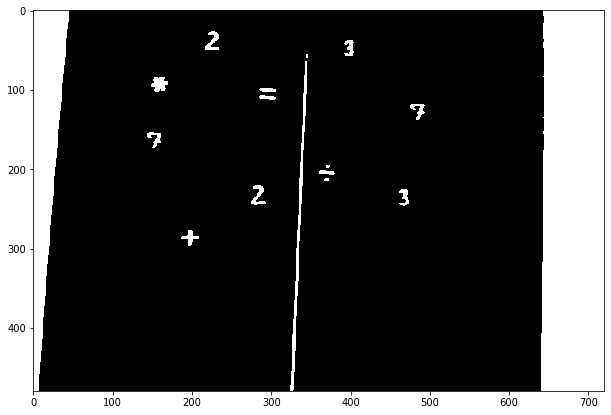

In [68]:
import skimage
from skimage import exposure
from skimage.filters import threshold_multiotsu
from skimage import morphology
# convert to grayscale 

test_im[minr_a-30:maxr_a+50, minc_a-30:maxc_a+50] = 255
plt.figure(figsize=(10,6))
plt.imshow(test_im)

gray = skimage.color.rgb2gray(test_im)

## Contrast stretching
a, b = np.percentile(gray, (1, 70))
img_rescale = exposure.rescale_intensity(gray, in_range=(a, b))

thresholds = threshold_multiotsu(img_rescale)

# Using the threshold values, we generate the three regions.
regions = np.digitize(gray, bins=thresholds)

plt.figure(figsize=(12,7))
plt.imshow(regions,cmap='gray')


# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(regions.ravel(), bins=100)
plt.axvline(thresholds[1], color='r')
plt.axvline(thresholds[0], color='r')
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('First digits Histogramm')


binarized = regions == 0

plt.figure(figsize=(12,7))
plt.imshow(binarized,cmap='gray')

close = morphology.binary_dilation(binarized, skimage.morphology.selem.rectangle(1, 3))
#close = morphology.binary_erosion(close, skimage.morphology.selem.disk(1))
#close = morphology.binary_dilation(close, skimage.morphology.selem.disk(1))

plt.figure(figsize=(12,7))
plt.imshow(close,cmap='gray')

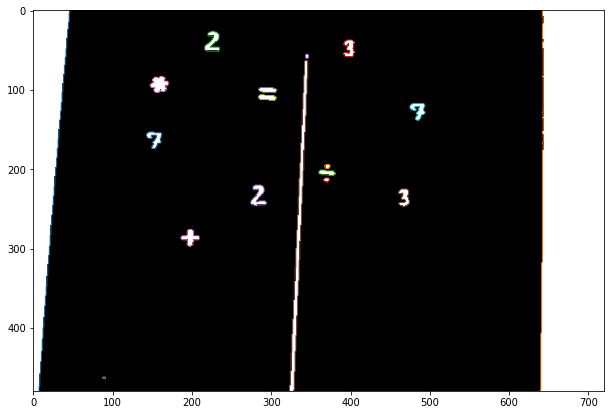

In [5]:
from skimage.measure import label, regionprops, find_contours
import numpy as np

contour = find_contours(close,0)
plt.figure(figsize=(12,7))
plt.imshow(close, cmap='gray')
for c in contour :
    plt.plot(c[:,1],c[:,0], linewidth = 1)

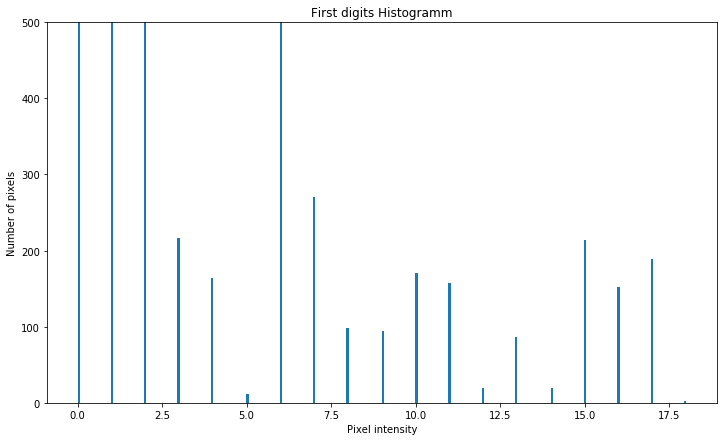

[292952  12211  37063    217    164     12   1503    271     98     95
    171    158     20     87     20    214    152    189      3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


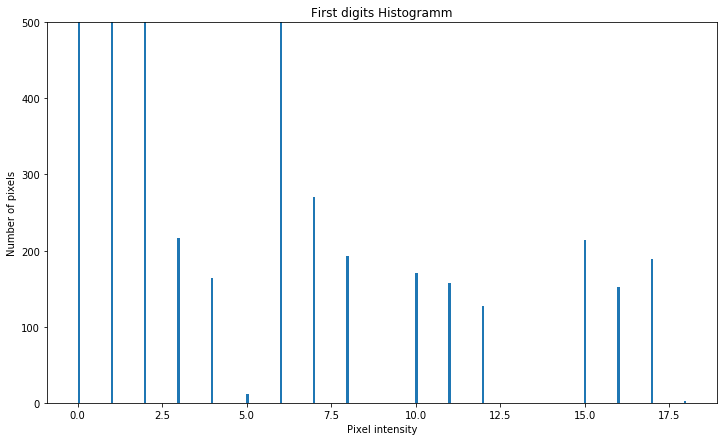

[292952  12211  37063    217    164     12   1503    271    193      0
    171    158    127      0      0    214    152    189      3]
[ 0  1  2  3  4  5  6  7  8 10 11 12 15 16 17 18]


In [81]:
# label image regions
label_image = label(close, background = 0, connectivity = 2)

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(label_image.ravel(), bins=256)
plt.ylim(0,500)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('First digits Histogramm')

plt.show()

freq = np.bincount(label_image.ravel())
ii = np.nonzero(freq)[0]
print(freq)
print(ii)

for i in range(len(np.bincount(label_image.ravel()))-1):
    if (abs(freq[i+1]-freq[i])<10) :
        idx = np.argwhere(label_image == ii[i+1])
        label_image[idx[:,0],idx[:,1]] = ii[i]
        
for i in range(len(np.bincount(label_image.ravel()))-2) :
    if (abs(freq[i+2]-freq[i])<5 and abs(freq[i+1]-freq[i])<75) :
        idx2 = np.argwhere(label_image == ii[i+2])
        idx1 = np.argwhere(label_image == ii[i+1])
        label_image[idx2[:,0],idx2[:,1]] = ii[i]
        label_image[idx1[:,0],idx1[:,1]] = ii[i]

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(label_image.ravel(), bins=256)
plt.ylim(0,500)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('First digits Histogramm')

plt.show()   

freq = np.bincount(label_image.ravel())
ii = np.nonzero(freq)[0]
print(freq)
print(ii)

In [82]:
def get_object_bb(labels):
    boxes = {}
    label = 0
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        # take regions with large enough areas
        if (region.area >= 50) and (maxr-minr) < 40:
            label += 1
            boxes['label_'+str(label)] = [minr, minc, maxr, maxc]    
    return boxes

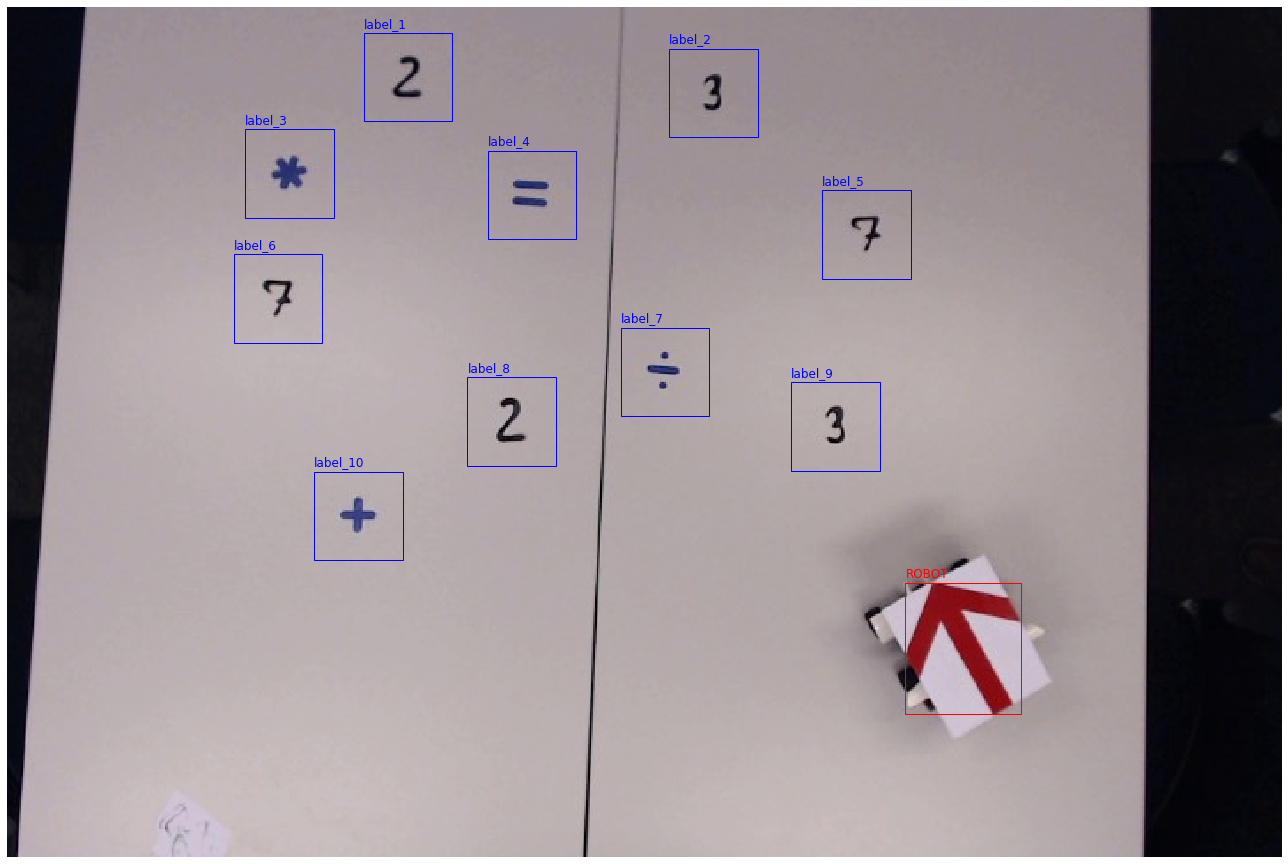

In [83]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(18, 14))
ax.imshow(images[0])
x, y = minc_a+(maxc_a-minc_a)/2, minr_a+(maxr_a-minr_a)/2
rect = mpatches.Rectangle((minc_a, minr_a), maxc_a - minc_a, maxr_a - minr_a, fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)
#ax.annotate('({}, {})'.format(x-(maxc_a - minc_a)/2, y-(maxr_a - minr_a)/2), (x-(maxc_a - minc_a)/2,y-3-(maxr_a - minr_a)/2), color='w', fontsize=12)
ax.annotate('ROBOT', (x-(maxc_a - minc_a)/2, y-3-(maxr_a - minr_a)/2), color='r', fontsize=12)

boxes = get_object_bb(label_image)

for box in boxes:
    minr, minc, maxr, maxc = boxes[box]
    x, y = minc+(maxc-minc)/2, minr+(maxr-minr)/2
    rect = mpatches.Rectangle((x-25, y-25), 50, 50, fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(rect)
    ax.annotate(box, (x-25, y-28), color='b', fontsize=12)

ax.set_axis_off()
plt.tight_layout()
plt.show()